## Face Fraud Detection - CNN

#### The rapid advancements in artificial intelligence (AI) have unleashed a world of possibilities, enabling machines to generate incredibly realistic images, including human faces. While this technological progress brings immense benefits, it also presents new challenges, particularly in the realm of fraud detection. With the proliferation of AI-generated faces, distinguishing between genuine and fabricated identities has become increasingly complex.

#### In this project, we delve into the fascinating realm of fraud face detection, where Convolutional Neural Networks (CNNs) have emerged as a powerful tool. CNNs, a subset of deep learning algorithms inspired by the human visual system, have revolutionized computer vision tasks and exhibit great promise in identifying fraudulent or synthetic faces. By training a CNN model specifically designed to discern the subtle discrepancies between AI-generated and real face images, we can unmask the fakes and fortify our defenses against identity-related fraud.

#### The goal of this project is to shed light on the potential of CNNs in combatting the rising tide of AI-generated face fraud. By leveraging the power of deep learning and computer vision, we can build systems capable of unmasking the fakes and preserving the integrity of our digital identities. Let us embark on this journey to understand how CNN models are leading the charge in this crucial battle between truth and deception.

### Face Fraud Detection using CNN with the following files:
#### In total there are 140k images, belonging to one of the follow classes:
* real -> 70k images
* fake -> 70k images

#### The data is split in the following datasets:

#### Train Dataset (100k images):
* *training fake -> 50k images*
* *training real -> 50k images*

#### Test Dataset (20k images):
* *test fake -> 10k images*
* *test real -> 10k images*

#### Validation Dataset (20k images):
* *valid fake -> 10k images*
* *valid real -> 10k images*

#### There is also a folder containg 100 images that were retreived by me, for the purpose to evaluate the accuracy of the model built and trained on images of my choice.
#### MyDataset:
* 50 real celebreties face images
* 50 AI generated face images from: https://this-person-does-not-exist.com/en

## Dependencies instalation

In [ ]:
!pip install livelossplot

## Imports

In [ ]:
import os
import cv2
import joblib
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import warnings
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import recall_score, accuracy_score, precision_score, classification_report
from livelossplot import PlotLossesKerasTF
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Notebook Parameters

In [7]:
input_directory_train ="/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train"
input_directory_test = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test"
input_directory_val = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid"

fake_input_directory_train = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake/"
real_input_directory_train = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real/"
fake_input_directory_test = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/"
real_input_directory_test = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/"
fake_input_directory_val = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/"
real_input_directory_val = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real/"

BATCH_SIZE_TRAIN=64
BATCH_SIZE_EVAL=32
BATCH_SIZE_TEST=32
EPOCHS=100
LEARNING_RATE=0.0005

## Size of data

In [8]:
print("Size of fake data train: ", len(os.listdir(fake_input_directory_train)))
print("Size of real data train: ", len(os.listdir(real_input_directory_train)))
print("Size of fake data test: ", len(os.listdir(fake_input_directory_test)))
print("Size of real data test: ", len(os.listdir(real_input_directory_test)))
print("Size of fake data val: ", len(os.listdir(fake_input_directory_val)))
print("Size of real data val: ", len(os.listdir(real_input_directory_val)))

Size of fake data train:  50000
Size of real data train:  50000
Size of fake data test:  10000
Size of real data test:  10000
Size of fake data val:  10000
Size of real data val:  10000


## Data Preparation and Treatment

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=10.,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #zoom_range=0.2,
    #horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale = 1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(input_directory_train,
                                                 target_size=(256,256),
                                                 batch_size = BATCH_SIZE_TRAIN,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(input_directory_test,
                                            target_size=(256,256),
                                            batch_size = BATCH_SIZE_TEST,
                                            class_mode = 'binary')

val_set = val_datagen.flow_from_directory(input_directory_val,
                                            target_size=(256,256),
                                            batch_size = BATCH_SIZE_EVAL,
                                            class_mode = 'binary')

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## Data Visualization

### Ploting the datasets by class

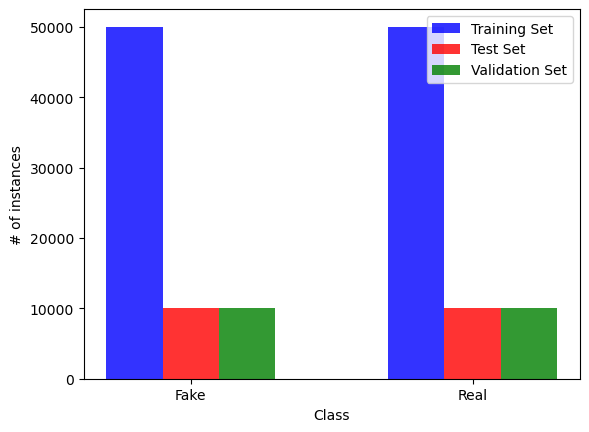

In [10]:
train_classes = training_set.classes
test_classes = test_set.classes
val_classes = val_set.classes

class_labels = ['Fake', 'Real']
class_indices = np.arange(len(class_labels))

train_counts = np.bincount(train_classes)
test_counts = np.bincount(test_classes)
val_counts = np.bincount(val_classes)

bar_width = 0.2

train_positions = class_indices - bar_width
test_positions = class_indices
val_positions = class_indices + bar_width

plt.bar(train_positions, train_counts, width=bar_width, color='blue', alpha=0.8, label='Training Set')
plt.bar(test_positions, test_counts, width=bar_width, color='red', alpha=0.8, label='Test Set')
plt.bar(val_positions, val_counts, width=bar_width, color='green', alpha=0.8, label='Validation Set')

plt.ylabel('# of instances')
plt.xlabel('Class')
plt.xticks(class_indices, class_labels, ha='center')
plt.legend()

plt.show()

### Visualizing a random image from the training set

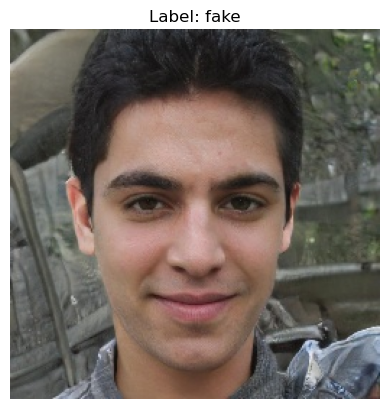

In [11]:
def plot_random_image(dataset):
    images, labels = next(dataset)

    random_index = random.randint(0, images.shape[0] - 1)
    image = images[random_index]
    label = labels[random_index]

    plt.imshow(image)
    if label == 0:
        label = "fake"
    else:
        label = "real"
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

    
plot_random_image(training_set)

## CNN Model

### Building the Model

In [61]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
           
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

### Compiling the Model 

In [62]:
optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

### Model Summary

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization_4 (Batc  (None, 254, 254, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 252, 252, 32)      18464     
                                                                 
 batch_normalization_5 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                      

### Training of the Model

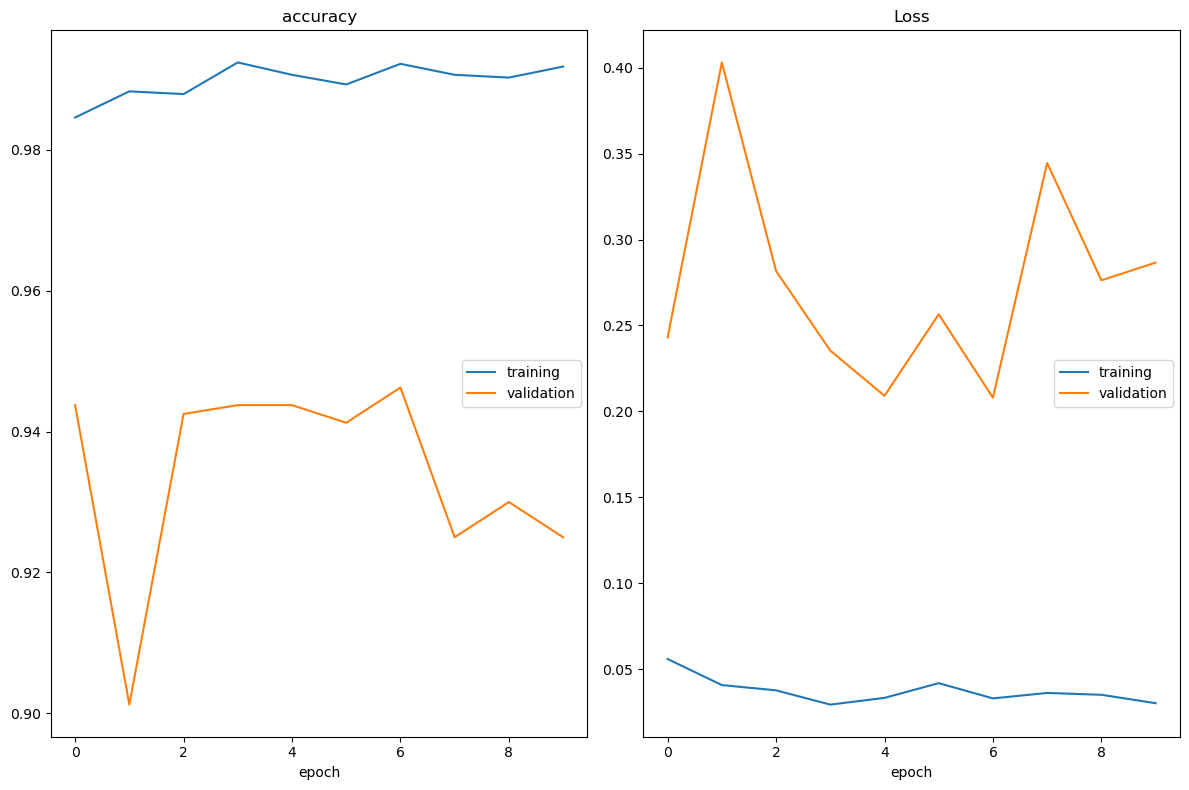

accuracy
	training         	 (min:    0.985, max:    0.992, cur:    0.992)
	validation       	 (min:    0.901, max:    0.946, cur:    0.925)
Loss
	training         	 (min:    0.029, max:    0.056, cur:    0.030)
	validation       	 (min:    0.208, max:    0.403, cur:    0.287)
80/80 [==============================] - 23s 288ms/step - loss: 0.0302 - accuracy: 0.9918 - val_loss: 0.2866 - val_accuracy: 0.9250


In [117]:
history = model.fit_generator(
        training_set,
        steps_per_epoch=80,
        epochs=10,
        validation_data=val_set,
        validation_steps=25,
        callbacks = [PlotLossesKerasTF()]
    )

## Evaluating the Model (Loss and Accuracy)

In [118]:
test_accuracy = model.evaluate_generator(test_set)[1]
print("Test Accuracy: ", test_accuracy)

Test Accuracy:  0.9323999881744385


## Tests

### Classification of a random test image

1/1 [==============================] - 0s 19ms/step


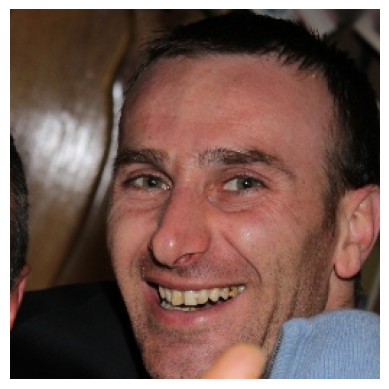

Label:  real
Prediction:  real


In [119]:
def classificating_random_image(dataset):
    images, labels = next(dataset)

    random_index = random.randint(0, images.shape[0] - 1)
    image = images[random_index]
    label = labels[random_index]
    
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    plt.imshow(image[0])
    
    if prediction[0] < 0.5:
        prediction = "fake"
    else:
        prediction = "real"
    if label == 0:
        label = "fake"
    else:
        label = "real"
    plt.axis('off')
    plt.show()
    print("Label: ", label)
    print("Prediction: ", prediction)

    
classificating_random_image(test_set)

### Manual Evaluation of the Model (Accuracy)

In [ ]:
def manual_test_accuracy(dataset, test_size):
    rights = 0

    for _ in range(test_size):
        images, labels = next(dataset)

        random_index = random.randint(0, images.shape[0] - 1)
        image = images[random_index]
        label = labels[random_index]

        image = np.expand_dims(image, axis=0)

        prediction = model.predict(image)

        if prediction[0] < 0.5:
            prediction = 0
        else:
            prediction = 1

        if label == prediction:
            rights += 1

    accuracy = rights / test_size
    return accuracy

NUMBER_OF_TESTS = 500
accuracy = manual_test_accuracy(test_set, NUMBER_OF_TESTS)

In [84]:
print("Accuracy:", accuracy)

Accuracy: 0.95


## Save the Model

In [136]:
joblib.dump(model, 'CNNFaceFraudDetectionModel.pkl')

['CNNFaceFraudDetectionModel.pkl']

## Load the Model

In [26]:
model = joblib.load('/kaggle/input/cnnmodel/CNNFaceFraudDetectionModel.pkl')

### Load Model Summary

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization_4 (Batc  (None, 254, 254, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 252, 252, 32)      18464     
                                                                 
 batch_normalization_5 (Batc  (None, 252, 252, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                      

### Evaluate the Loaded Model

In [ ]:
test_accuracy = model.evaluate_generator(test_set)[1]
print("Test Accuracy: ", test_accuracy)

### Data Preparation

In [120]:
my_test_datagen = ImageDataGenerator(rescale = 1./255)

my_test_set = my_test_datagen.flow_from_directory("/kaggle/input/faces-mydataset/Faces MyDataset",
                                                 target_size=(256,256),
                                                 batch_size = 100,
                                                 class_mode = 'binary')

Found 100 images belonging to 2 classes.


### Manual Evaluation of the Model (Accuracy) on MyDataset

In [ ]:
NUMBER_OF_TESTS=1000
accuracy = manual_test_accuracy(my_test_set, NUMBER_OF_TESTS)

In [123]:
print("Accuracy:", accuracy)

Accuracy: 0.587


### Classification of a random image from MyDataset

1/1 [==============================] - 0s 21ms/step


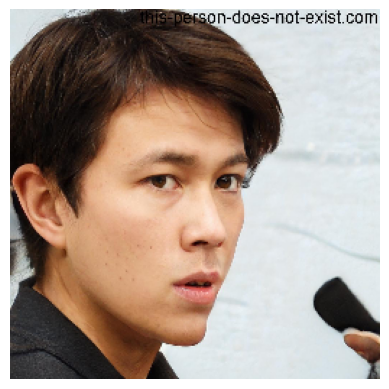

Label:  fake
Prediction:  fake


In [135]:
classificating_random_image(my_test_set)